# Supplementary figure (Simulations)

In [72]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [73]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [74]:
# general
import sys
import os

In [75]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from scipy.stats import probplot

sc.settings.verbosity = 3

In [76]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# local
sys.path.append('..')
from utils import settings
from utils import dataloader

## Plot settings

In [78]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
sns.set_style("ticks")

In [79]:
FIGURE_NUMBER = 'supp1'
PANEL_COUNTS = 1

def save_panel(fig):
    global PANEL_COUNTS
    
    fig_dir = 'figures/fig%s' % FIGURE_NUMBER
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig.savefig(fig_dir + '/panel_%d.svg' % PANEL_COUNTS, dpi=350)
    PANEL_COUNTS += 1

In [80]:
TEST_COLORS = {
    'DALI-Het': '#1f77b4',
    'DALI-Hom': '#ff7f0e',
    'DALI-Joint': '#2ca02c',
    't-Test': '#d62728'
}

## Load simulations

In [81]:
ALPHA_CUTOFF = .05

In [82]:
def compute_discoveries(fname):
    return(pd.read_csv(os.path.join(sim_path, fname), index_col=0) < ALPHA_CUTOFF).mean()

In [83]:
sim_path = os.path.join(settings.DATA_DIR, label, 'simulations')

In [84]:
def split_filename(fname):
    fprops = dict([e.split('_') for e in fname.replace('.txt', '').split('-')])
    fprops['filename'] = fname
    return fprops

In [85]:
df = pd.DataFrame([split_filename(f) for f in os.listdir(sim_path)])
df['model'] = df['model'].replace({
    'dalihet': 'DALI-Het',
    'lrt': 'DALI-Hom',
    'dalijoint': 'DALI-Joint',  
    'ttest': 't-Test'
}).astype('category')
df[['simkernvar', 'simkernmix', 'simoverdisp']] = df[['simkernvar', 'simkernmix', 'simoverdisp']].astype(float)

In [86]:
df = df.query('result == "pvals"')
df['power'] = df['filename'].apply(compute_discoveries)

## Plot power

Het+Global

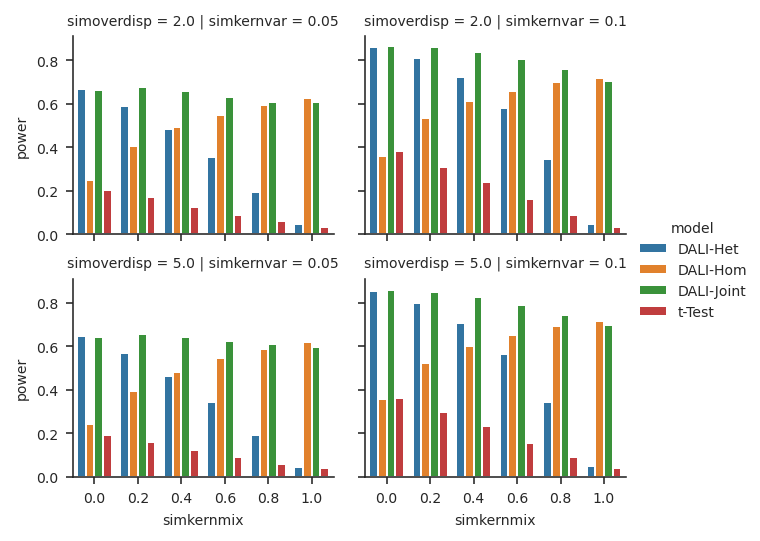

In [87]:
g = sns.catplot(
    x='simkernmix', y='power', kind='bar', hue='model', 
    col='simkernvar', row='simoverdisp', 
    data=df.query('simkerndisc == "global" and simkernvar > 0.01'),
    palette=TEST_COLORS, height=1.8, aspect=1.2)
save_panel(g.fig)

Het+Discrete

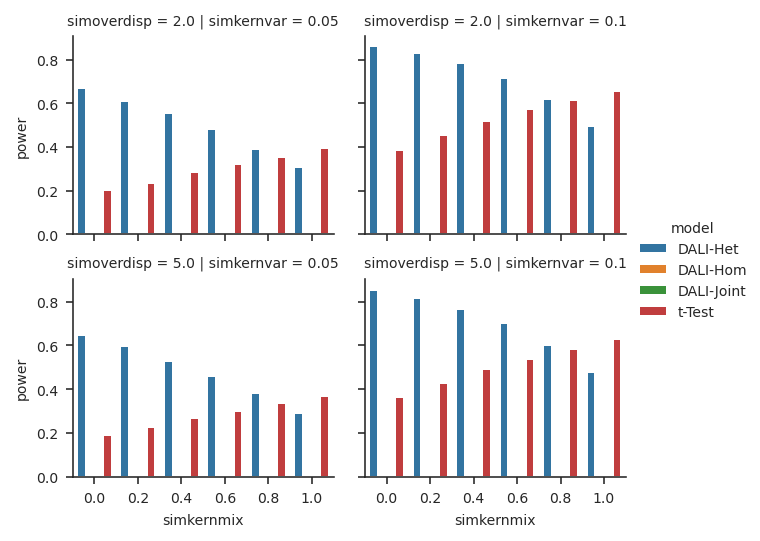

In [88]:
g = sns.catplot(
    x='simkernmix', y='power', kind='bar', hue='model', 
    col='simkernvar', row='simoverdisp', 
    data=df.query('simkerndisc == "cluster" and simkernvar > .01'),
    palette=TEST_COLORS, height=1.8, aspect=1.2)
save_panel(g.fig)

## Theta distribution

In [89]:
fname = '_'.join(['SS148', regions, correction, 'allelic_counts.h5ad'])
adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))

In [90]:
A = adata.X.A
D = adata.layers['allelic_total'].A

In [91]:
from dali.utils.stats import fit_polya, reparameterize_polya_alpha

In [92]:
# alphas = list()
# for i in range(adata.shape[1]):
#     print(i, end='\r')
#     a = A[:, i]
#     d = D[:, i]
#     a = a[d > 0]
#     d = d[d > 0]
#     alpha, _ = fit_polya(data = np.vstack([a, d-a]).T)
#     alphas.append(alpha)

# params = [reparameterize_polya_alpha(a) for a in alphas]
# mus = [p[0][0] for p in params]
# thetas = [1/p[1] for p in params]

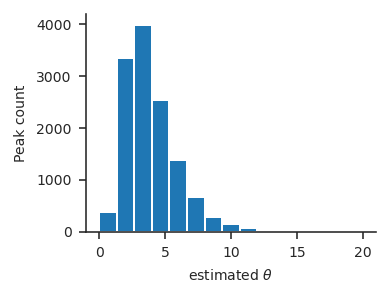

In [93]:
fig, ax = plt.subplots(figsize=(2.6, 2))
ax.hist(thetas, bins=15, range=(0, 20))
ax.set(xlabel=r'estimated $\theta$', ylabel='Peak count')
sns.despine()
save_panel(fig)

## Null distribution

In [94]:
def compute_quantiles(fname):
    x = pd.read_csv(os.path.join(sim_path, fname), index_col=0).to_numpy().flatten()
    (osm, osr), _ = scipy.stats.probplot(x, dist='uniform')
    return pd.DataFrame({'osm': -np.log10(osm), 'osr': -np.log10(osr)})

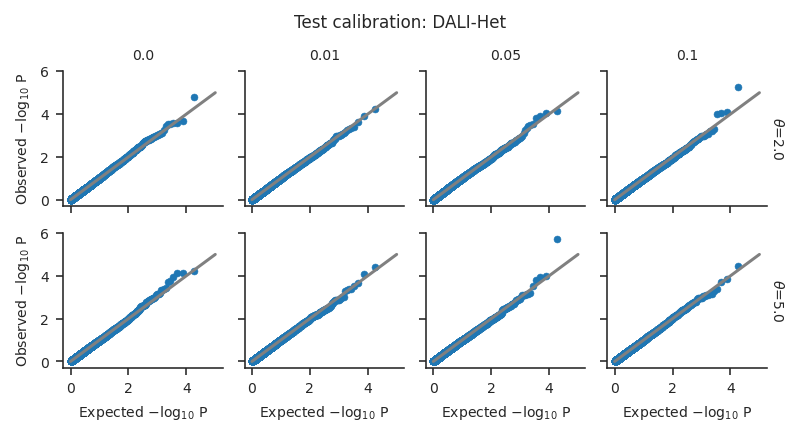

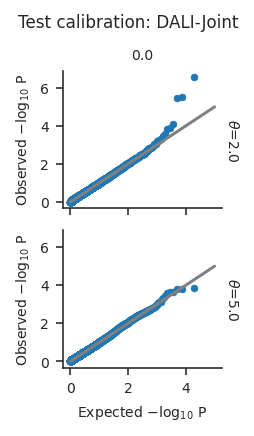

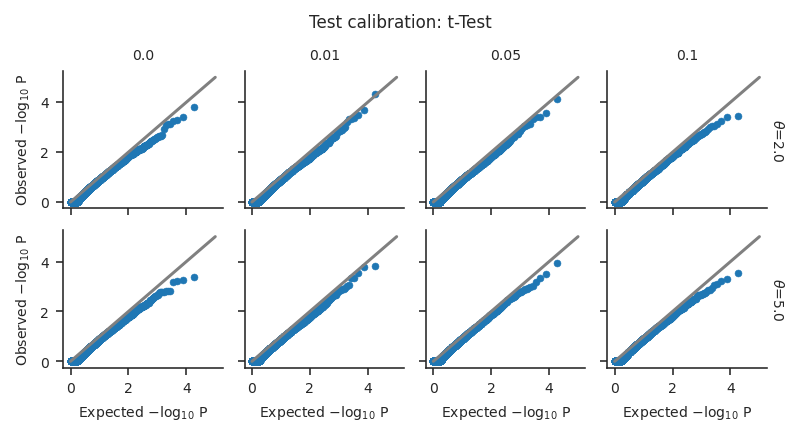

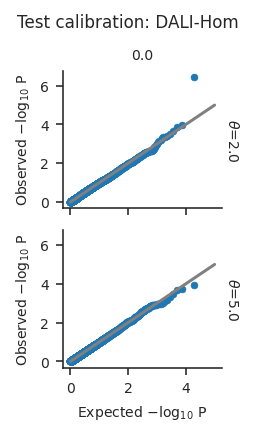

In [95]:
for model in df['model'].unique():

    if model in ['t-Test', 'DALI-Het']:
        df_sub = df.query('model == @model and (simkernmix == 1 or simkernvar == 0) and simkerndisc == "global"').reset_index(drop=True)
        aspect = 1
    else:
        df_sub = df.query('model == @model and simkernvar == 0').reset_index(drop=True)
        aspect = 1.3
    df_qq = pd.DataFrame()
    for i in df_sub.index:
        df_qq_sub = compute_quantiles(df_sub.loc[i, 'filename'])
        df_qq_sub['model'] = df_sub.loc[i, 'model']
        df_qq_sub['simoverdisp'] = df_sub.loc[i, 'simoverdisp']
        df_qq_sub['simkernvar'] = df_sub.loc[i, 'simkernvar']
        df_qq = pd.concat([df_qq, df_qq_sub], axis=0)

    g = sns.FacetGrid(data=df_qq, row='simoverdisp', col='simkernvar', margin_titles=True, height=1.4, aspect=aspect)
    g.map_dataframe(sns.scatterplot, x='osm', y='osr', edgecolor=None, rasterized=True, s=12)
    for ax in g.fig.axes:
        ax.plot([0, 5], [0, 5], color='grey')
    g.set_axis_labels(r'Expected $-\log_{10}$ P', r'Observed $-\log_{10}$ P')
    g.set_titles(col_template='{col_name}', row_template=r'$\theta$={row_name}')
    g.fig.suptitle('Test calibration: %s' % model, y=1.05)
    g.tight_layout()
    plt.show()
    save_panel(g.fig)

## Kernel matrices

In [96]:
from dali.utils.simulate import create_linear_kernel, create_cluster_kernel

In [97]:
np.random.seed(123)

In [98]:
N = 1000

In [99]:
fname = '_'.join(['SS148', regions, correction, 'allelic_counts.h5ad'])
adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
adata = adata[np.random.choice(adata.shape[0], 1000, replace=False), :]
adata = adata[adata.obs['leiden_vae'].sort_values().index, :]

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [100]:
K_hom = np.ones((N, N))
K_vae = create_linear_kernel(adata.obsm['X_vae'])
K_leiden = create_cluster_kernel(adata.obs['leiden_vae'])

K_vae = (K_vae - K_vae.min()) / (K_vae.max() - K_vae.min())

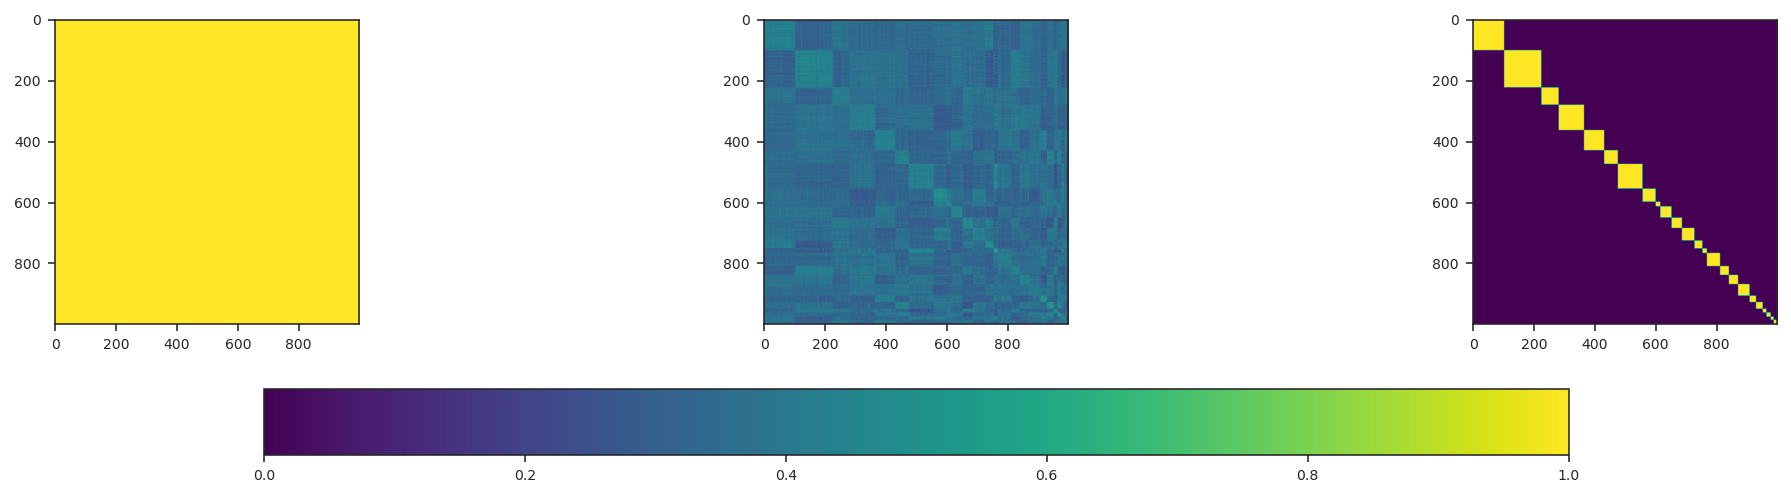

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
ax = axes[0]
p = ax.imshow(K_hom, cmap=plt.cm.viridis, vmin=0, vmax=1)
ax = axes[1]
p = ax.imshow(K_vae, cmap=plt.cm.viridis, vmin=0, vmax=1)
ax = axes[2]
p = ax.imshow(K_leiden, cmap=plt.cm.viridis, vmin=0, vmax=1)
plt.colorbar(p, ax=axes, orientation='horizontal')
save_panel(fig)